In [46]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 


# Any results you write to the current directory are saved as output.

%matplotlib inline
import pandas as pd
import numpy as np

import os
from sklearn.metrics.classification import accuracy_score, log_loss
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.optimizers import Adam

In [11]:
data = pd.read_csv('../input/training_variants')
data.head()

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [12]:
# check nan value
data.isnull().sum()

ID           0
Gene         0
Variation    0
Class        0
dtype: int64

In [17]:
# note the seprator in this file
data_text =pd.read_csv("../input/training_text",sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)
data_text.head()


,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


In [18]:
# check the null value in data_text
data_text.isnull().sum()

ID      0
TEXT    5
dtype: int64

In [19]:
data_text.dropna(axis=0,how='any',inplace=True)

In [20]:
data_text.isnull().sum()

ID      0
TEXT    0
dtype: int64

In [22]:
# preprocessing for data_text
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
def nlp_preprocessing(total_text,index,column):
    if type(total_text) is not int:
        string = ""
        # replace every special char with space
        total_text = re.sub('[^a-zA-Z0-9\n]',' ',total_text)
        # replace multiple spaces with single space
        total_text = re.sub('\s+',' ',total_text)
        # converting all the chars into lower-case.
        total_text= total_text.lower()
        
        for word in total_text.split():
            # if the word is a not a stop word then retain that word from the data
            if not word in stop_words:
                string += word+' '
                
        data_text[column][index] = string
        
        
    

In [25]:
#text processing stage.
import time
import re
start_time = time.clock()
for index, row in data_text.iterrows():
    nlp_preprocessing(row['TEXT'], index, 'TEXT')
print('Time took for preprocessing the text :',time.clock() - start_time, "seconds")

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Time took for preprocessing the text : 326.160353 seconds


In [26]:
#merging both gene_variations and text data based on ID
df_train = pd.merge(data,data_text,on= 'ID',how = 'left')
df_train.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [28]:
df_train['full_text'] = df_train[['Gene','Variation']].apply(lambda x: ' '.join(x),axis=1)

In [31]:
df_train['TEXT'] = df_train['TEXT'].astype(str)

In [32]:
df_train['full_text'] = df_train[['full_text','TEXT']].apply(lambda x: ' '.join(x),axis=1)

In [33]:
df_train.head()

,ID,Gene,Variation,Class,TEXT,full_text
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...,FAM58A Truncating Mutations cyclin dependent k...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...,CBL W802* abstract background non small cell l...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...,CBL Q249E abstract background non small cell l...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...,CBL N454D recent evidence demonstrated acquire...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...,CBL L399V oncogenic mutations monomeric casita...


In [34]:
# Use the Keras tokenizer
num_words = 2000
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(df_train['full_text'].values)

In [35]:
# Pad the data 
X = tokenizer.texts_to_sequences(df_train['full_text'].values)
X = pad_sequences(X, maxlen=2000)

In [36]:
# Build out our simple LSTM
embed_dim = 128
lstm_out = 196

# Model saving callback
ckpt_callback = ModelCheckpoint('keras_model', 
                                 monitor='val_loss', 
                                 verbose=1, 
                                 save_best_only=True, 
                                 mode='auto')

model = Sequential()
model.add(Embedding(num_words, embed_dim, input_length = X.shape[1]))
model.add(LSTM(lstm_out, recurrent_dropout=0.2, dropout=0.2))
model.add(Dense(9,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['categorical_crossentropy'])
print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2000, 128)         256000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 196)               254800    
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 1773      
Total params: 512,573
Trainable params: 512,573
Non-trainable params: 0
_________________________________________________________________
None


In [38]:
from sklearn.model_selection import train_test_split
Y = pd.get_dummies(df_train['Class']).values
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42, stratify=Y)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(2656, 2000) (2656, 9)
(665, 2000) (665, 9)


In [39]:
batch_size = 32
history = model.fit(X_train, Y_train, epochs=8, batch_size=batch_size, validation_split=0.2, 
                    callbacks=[ckpt_callback])

Instructions for updating:
Use tf.cast instead.
Train on 2124 samples, validate on 532 samples
Epoch 1/8
2124/2124 [==============================] - 355s 167ms/step - loss: 1.8515 - categorical_crossentropy: 1.8515 - val_loss: 1.6914 - val_categorical_crossentropy: 1.6914

Epoch 00001: val_loss improved from inf to 1.69137, saving model to keras_model
Epoch 2/8
2124/2124 [==============================] - 349s 165ms/step - loss: 1.4237 - categorical_crossentropy: 1.4237 - val_loss: 1.3465 - val_categorical_crossentropy: 1.3465

Epoch 00002: val_loss improved from 1.69137 to 1.34653, saving model to keras_model
Epoch 3/8
2124/2124 [==============================] - 347s 163ms/step - loss: 1.1351 - categorical_crossentropy: 1.1351 - val_loss: 1.2680 - val_categorical_crossentropy: 1.2680

Epoch 00003: val_loss improved from 1.34653 to 1.26795, saving model to keras_model
Epoch 4/8
2124/2124 [==============================] - 346s 163ms/step - loss: 0.9346 - categorical_crossentropy: 0.9

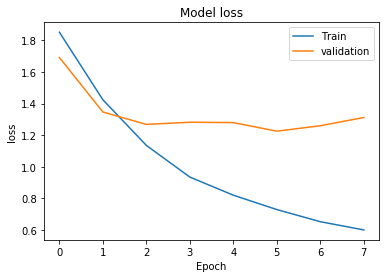

In [41]:
# Plot training & validation accuracy values
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'validation'], loc='best')
plt.show()

In [42]:
model = load_model('keras_model')

In [43]:
probas = model.predict(X_test)

In [47]:
pred_indices = np.argmax(probas, axis=1)
classes = np.array(range(1, 10))
preds = classes[pred_indices]
print('Log loss: {}'.format(log_loss(classes[np.argmax(Y_test, axis=1)], probas)))
print('Accuracy: {}'.format(accuracy_score(classes[np.argmax(Y_test, axis=1)], preds)))

Log loss: 1.2986269544754037
Accuracy: 0.5593984962406015


In [51]:
# This function plots the confusion matrices given y_i, y_i_hat.
from sklearn.metrics import confusion_matrix
import seaborn as sns
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    
    labels = [1,2,3,4,5,6,7,8,9]
    # representing C in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    # representing B in heatmap format FOR PRECISION
    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing A in heatmap format FOR RECALL
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


-------------------- Confusion matrix --------------------


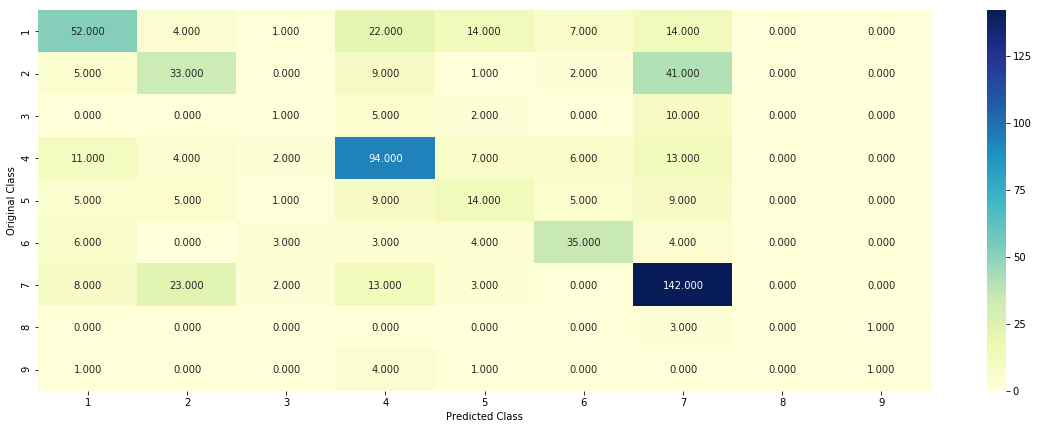

-------------------- Precision matrix (Columm Sum=1) --------------------


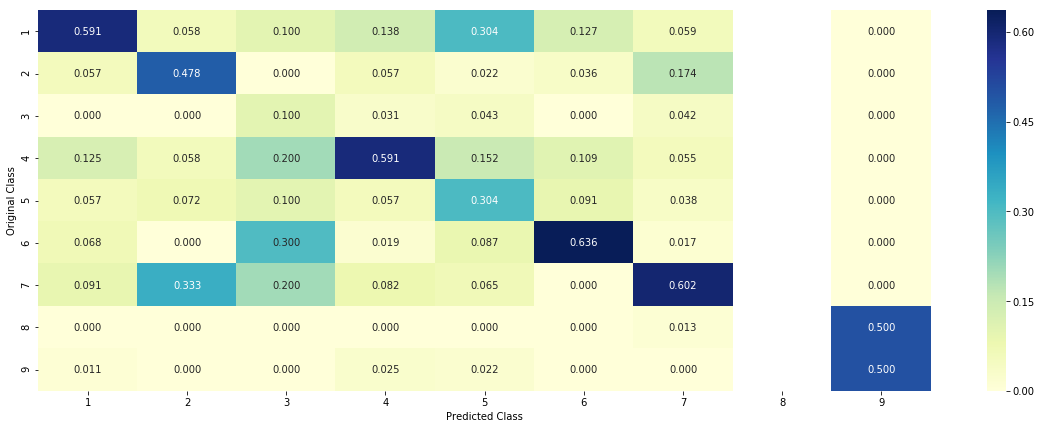

-------------------- Recall matrix (Row sum=1) --------------------


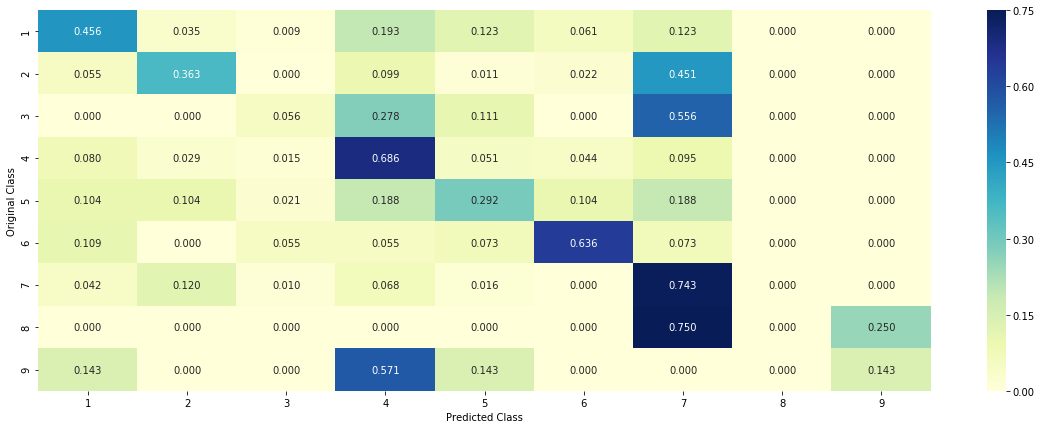

In [52]:
plot_confusion_matrix(classes[np.argmax(Y_test, axis=1)], preds)